In [5]:
# written to merge networks from drugs
# associated with the same DMEs
# re-written 9-18-19, JLW

import pickle,os,csv,itertools,functools, random, math, matplotlib
import networkx as nx
from collections import defaultdict
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from networkx.drawing.nx_agraph import graphviz_layout, to_agraph
# import pygraphviz as pgv
# from pyvis.network import Network
# from colour import Color
import matplotlib.cm as cm
# import plotly.graph_objects as go

dd_dic = functools.partial(defaultdict, dict)
dd_list = functools.partial(defaultdict,list)

# resources for mapping
dintf = '../data/drug_intome_targets.pkl'
dint = pickle.load(open(dintf,'rb')) # to find number of drug targets
db2nf = '../data/drugbankid_to_name.pkl'
db2n = pickle.load(open(db2nf,'rb'))
print('loaded mapping files')

# feature importance from logistic regression
fi_res_dir = '../ML_network_positives_negatives/log_reg/'
froot = '_feat_imp_scores_092920.pkl'
allf = [f for f in os.listdir(fi_res_dir) if froot in f]
fi_dic = dict([(f.replace(froot,''),os.path.join(fi_res_dir,f)) for f in allf])
print('loaded feature importance data')

# dictionary to look up drug network results
nfdir = '../all_drugbank_network_files/'
nfs = [f for f in os.listdir(nfdir)]
nf_dic = dict([(f.split('_')[0],os.path.join(nfdir,f)) for f in nfs if 'merged_neighborhood_.txt' in f])
print('loaded network files')

# DEVELOPMENT CODE #Load merged networks, but add interactions from false positives
#true_positives_f = 'true_positives_dbid.pkl'
#true_positives_dbid = pickle.load(open(true_positives_f,'rb'))
#dme_net_f = {}
#dme_net_data = {}
#for dme in true_positives_dbid:
#    dme_net_f[dme] = os.path.join(dme_mdir,dme+'merged_net.pkl')
#    dme_net_data[dme] = os.path.join(dme_mdir,dme+'zipped_net_data.pkl')
#print([k for k in true_positives_dbid.keys()])


loaded mapping files
loaded feature importance data
loaded network files


In [6]:
# load the positive and negative lists of DrugBank IDs
negf = '../drugs_to_dmes_false_positives.txt'
posf = '../drugs_to_dmes_true_positive.txt'

dme_dic = defaultdict(dd_list)

dR = csv.DictReader(open(posf,'r'),delimiter='\t')
for r in dR:
    DME = r['Label DME']
    dbid = r['DrugBankID']
    pathfx_phen = r['PathFX Phenotype']
    genes = r['Network genes assoc to phen']
    dme_dic[DME]['positives'].append((dbid,pathfx_phen,genes))
    
dR = csv.DictReader(open(negf,'r'),delimiter='\t')
for r in dR:
    DME = r['False Positive DME']
    dbid = r['DrugBankID']
    pathfx_phen = r['PathFX Phenotype']
    genes = r['Network genes assoc to phen']
    dme_dic[DME]['negatives'].append((dbid,pathfx_phen,genes))



In [7]:
def pairwise(iterable):
    a,b = itertools.tee(iterable)
    next(b,None)
    return zip(a,b)

In [8]:
def create_layer_array(layer_num,nrows,min_positions,fig_width,squish):
    # for phenotype layer, reduce the number of rows
    if layer_num == 1:
        nrows = 2
        ymin = 1.3
        ymax = 1.5
    else:
        ymin = layer_num - 0.4
        ymax = layer_num + 0.4
        
    if squish and layer_num != 4:
        if layer_num == 3:
            nrows = 2
            ymin = (0.1)*layer_num - 0.045
            ymax = (0.1)*layer_num + 0.0045
        else:
            ymin = 0.3
            ymax = 0.6
    elif squish and layer_num == 4:
        ymin = 0.75
        ymax = 1.75
    
    min_cols = math.ceil(float(min_positions)/nrows)
    act_cols = min_cols *4
    layer_arr = []
    for x1 in np.linspace(0,fig_width,act_cols):
        for y1 in np.linspace(ymin,ymax,nrows):
            layer_arr.append((x1,y1))
    return layer_arr

In [9]:
def assign_layer_positions(layer_arr,node_list):
    layer_pos = {}
    for n in node_list:
        rand_ind = np.random.choice(range(len(layer_arr)))
        (xd,yd) = layer_arr[rand_ind]
        layer_pos[n] = (xd,yd)
        layer_arr.remove((xd,yd))
    return layer_pos

In [10]:
def get_layered_positions(ntd,nrows,fig_width,squish):
    all_pos = {}
    drugs = [n for (n,nt) in ntd.items() if nt == 'positive_drug' or nt == 'negative_drug']
    num_drugs = len(drugs)
    drug_layer = create_layer_array(4,nrows,num_drugs,fig_width,squish)
    drug_pos = assign_layer_positions(drug_layer,drugs)
    all_pos.update(drug_pos)
    
    drug_targets = [n for (n,nt) in ntd.items() if nt == 'drug_target']
    num_dts = len(drug_targets)
    dt_layer = create_layer_array(3,nrows,num_dts,fig_width,squish)
    dt_pos = assign_layer_positions(dt_layer,drug_targets)
    all_pos.update(dt_pos)
  
    intermed = [n for (n,nt) in ntd.items() if nt == 'intermediate']
    num_inter = len(intermed)
    inter_layer = create_layer_array(2,nrows,num_inter,fig_width,squish)
    inter_pos = assign_layer_positions(inter_layer,intermed)
    all_pos.update(inter_pos)
    
    phenotypes = [n for (n,nt) in ntd.items() if nt == 'phenotype']
    num_ph = len(phenotypes)
    ph_layer = create_layer_array(1,nrows,num_ph,fig_width,squish)
    ph_pos = assign_layer_positions(ph_layer,phenotypes)
    all_pos.update(ph_pos)

    return all_pos

In [11]:
# load the networks and save network data
dme_merged_networks = {}
dme_merged_node_data = {}
for (dme,pos_neg_dic) in dme_dic.items():
    print(dme)
    pos_drug_list = pos_neg_dic['positives']
    neg_drug_list = pos_neg_dic['negatives']
    
    mG = nx.Graph()
    node_data = defaultdict(dd_list)
    merge_edges = set()
    node_counts = defaultdict(int)
    for [drug_list,drugs_type] in [[pos_drug_list,'positive_drug'],[neg_drug_list,'negative_drug']]:
        for (dbid,pathfx_phen,genes) in drug_list:
            dname = db2n[dbid]
            dtargs = dint[dbid]
        
            # get and load drug network
            netf = nf_dic[dbid]
            fh=open(netf, 'rb')
            tG=nx.read_edgelist(fh, delimiter='\t',nodetype=str,data=(('weight',float),))
        
            # select out interaction pathways for phenotype of interest
            goi = genes.split(',') # genes of interest to phenotype
            pth_nodes = set()
            for dt in dtargs: # look for paths b/t drug targets and phenotype-associated genes
                for g in goi:
                    aspths = nx.all_shortest_paths(tG,source=dt,target=g)
                    for short_pth in aspths:
                        ind_edges = pairwise(short_pth)
                        for (a,b) in ind_edges: ### NEED TO UPDATE COUNTS HERE
                            merge_edges.add((a,b))
                            pth_nodes.add(a)
                            pth_nodes.add(b)
            # store counts
            for n in pth_nodes:
                node_counts[n]+=1 # even if there are multiple shortest paths, only count them once for a drug-pheno relationship
                        
            # add drug-to-target interactions
            for dt in dtargs:
                merge_edges.add((dname,dt))
        
            # add gene-to-phenotype interactions
            for g in goi:
                merge_edges.add((g,pathfx_phen))
                
        
            # store node data
            node_data[dname]['type'] = drugs_type
            node_data[dname]['shape'] = '^'
            node_data[pathfx_phen]['type'] = 'phenotype'
            node_data[pathfx_phen]['shape'] = 's'
            for dt in dtargs:
                node_data[dt]['type'] = 'drug_target'
                node_data[dt]['shape'] = '8'
            
    # after mergine add size data for counted nodes
    for (n,nc) in node_counts.items():
        node_data[n]['count'] = nc
    
    mG.add_edges_from(list(merge_edges))
    outf1 = dme+'_merged_network_nx.pkl'
    outf2 = dme+'_merged_network_node_data.pkl'
    
    dme_merged_networks[dme] = outf1
    dme_merged_node_data[dme] = outf2
    
    pickle.dump(mG,open(outf1,'wb'))
    pickle.dump(node_data,open(outf2,'wb'))

pickle.dump(dme_merged_networks,open('dme_merged_networks_dic.pkl','wb'))
pickle.dump(dme_merged_node_data,open('dme_merged_node_data_dic.pkl','wb'))

Myopathy
Myocardial infarction
Hypertension
Delirium
Peripheral neuropathy
Pancreatitis
Edema
Hemorrhage
Cardiac arrest
Sepsis
Thrombocytopenia
Gastric ulcer
Pneumonia
Tardive dyskinesia
Hyperlipidemia
Proteinuria
Hemolytic anemia
Hepatic necrosis
Agranulocytosis
Cerebral infarction
Ventricular tachycardia
Pulmonary edema
Interstitial lung disease
Deep vein thrombosis
Stevens-Johnson Syndrome
Visual acuity reduced


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

254


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

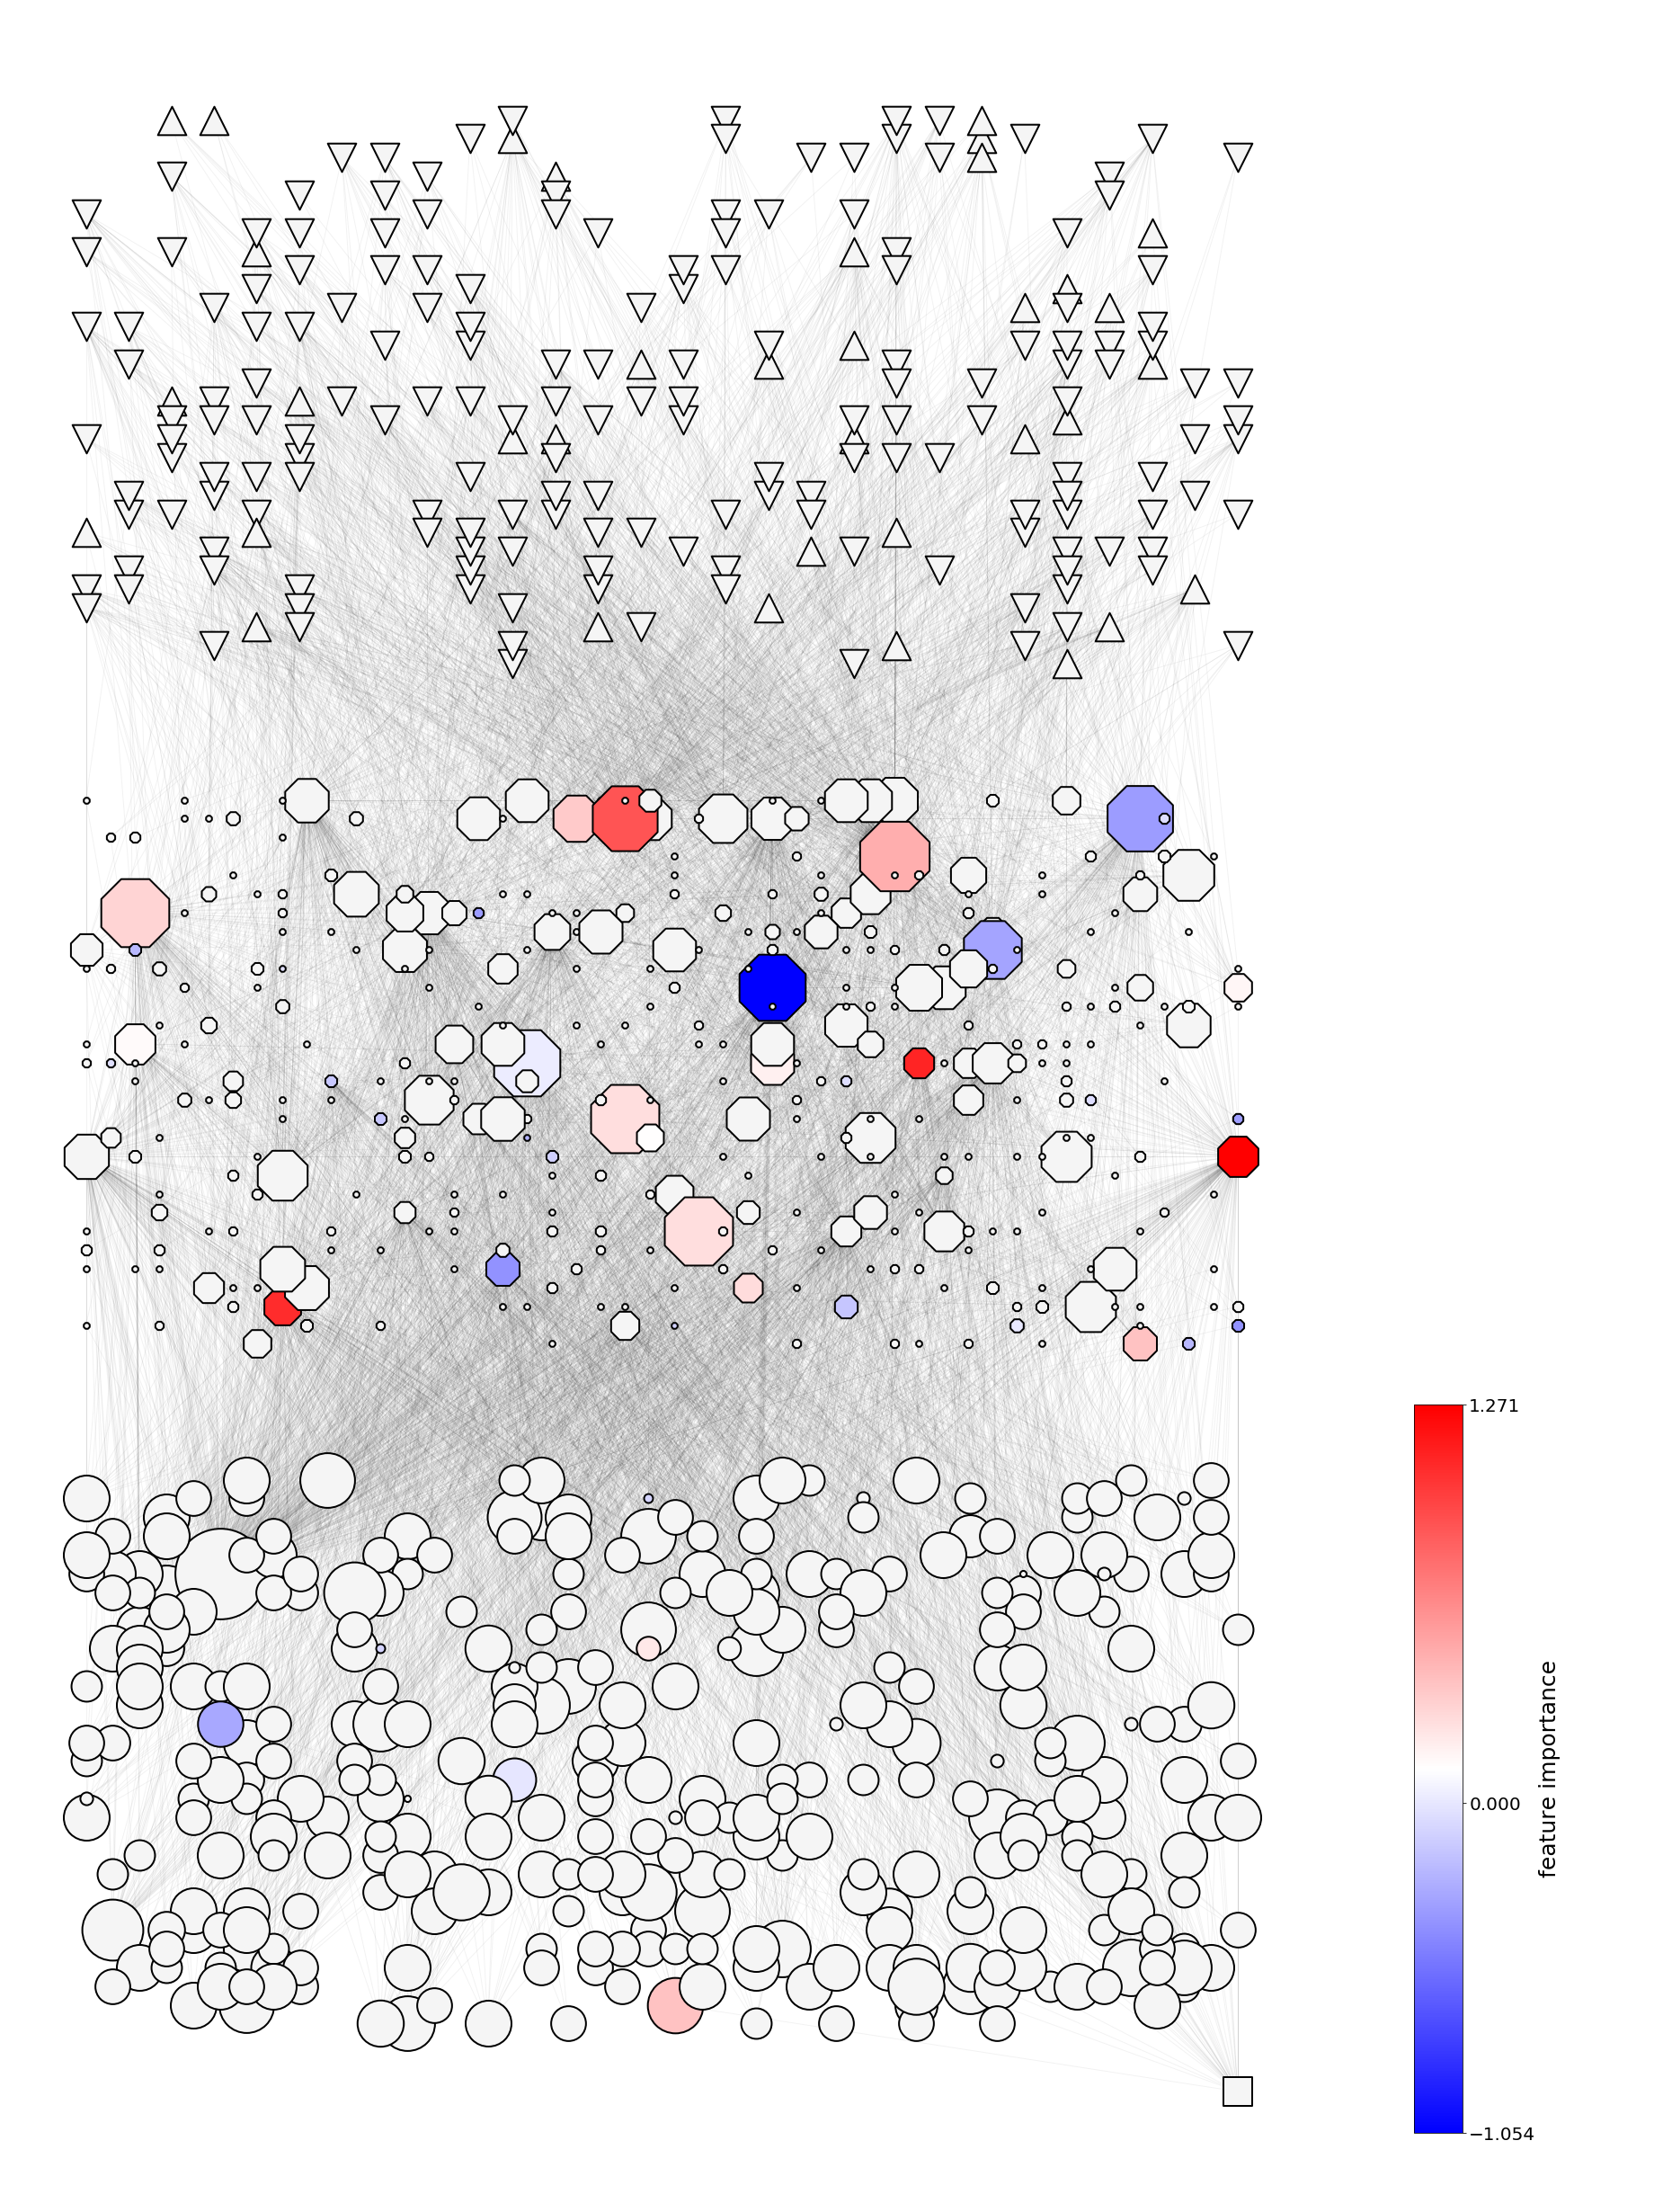

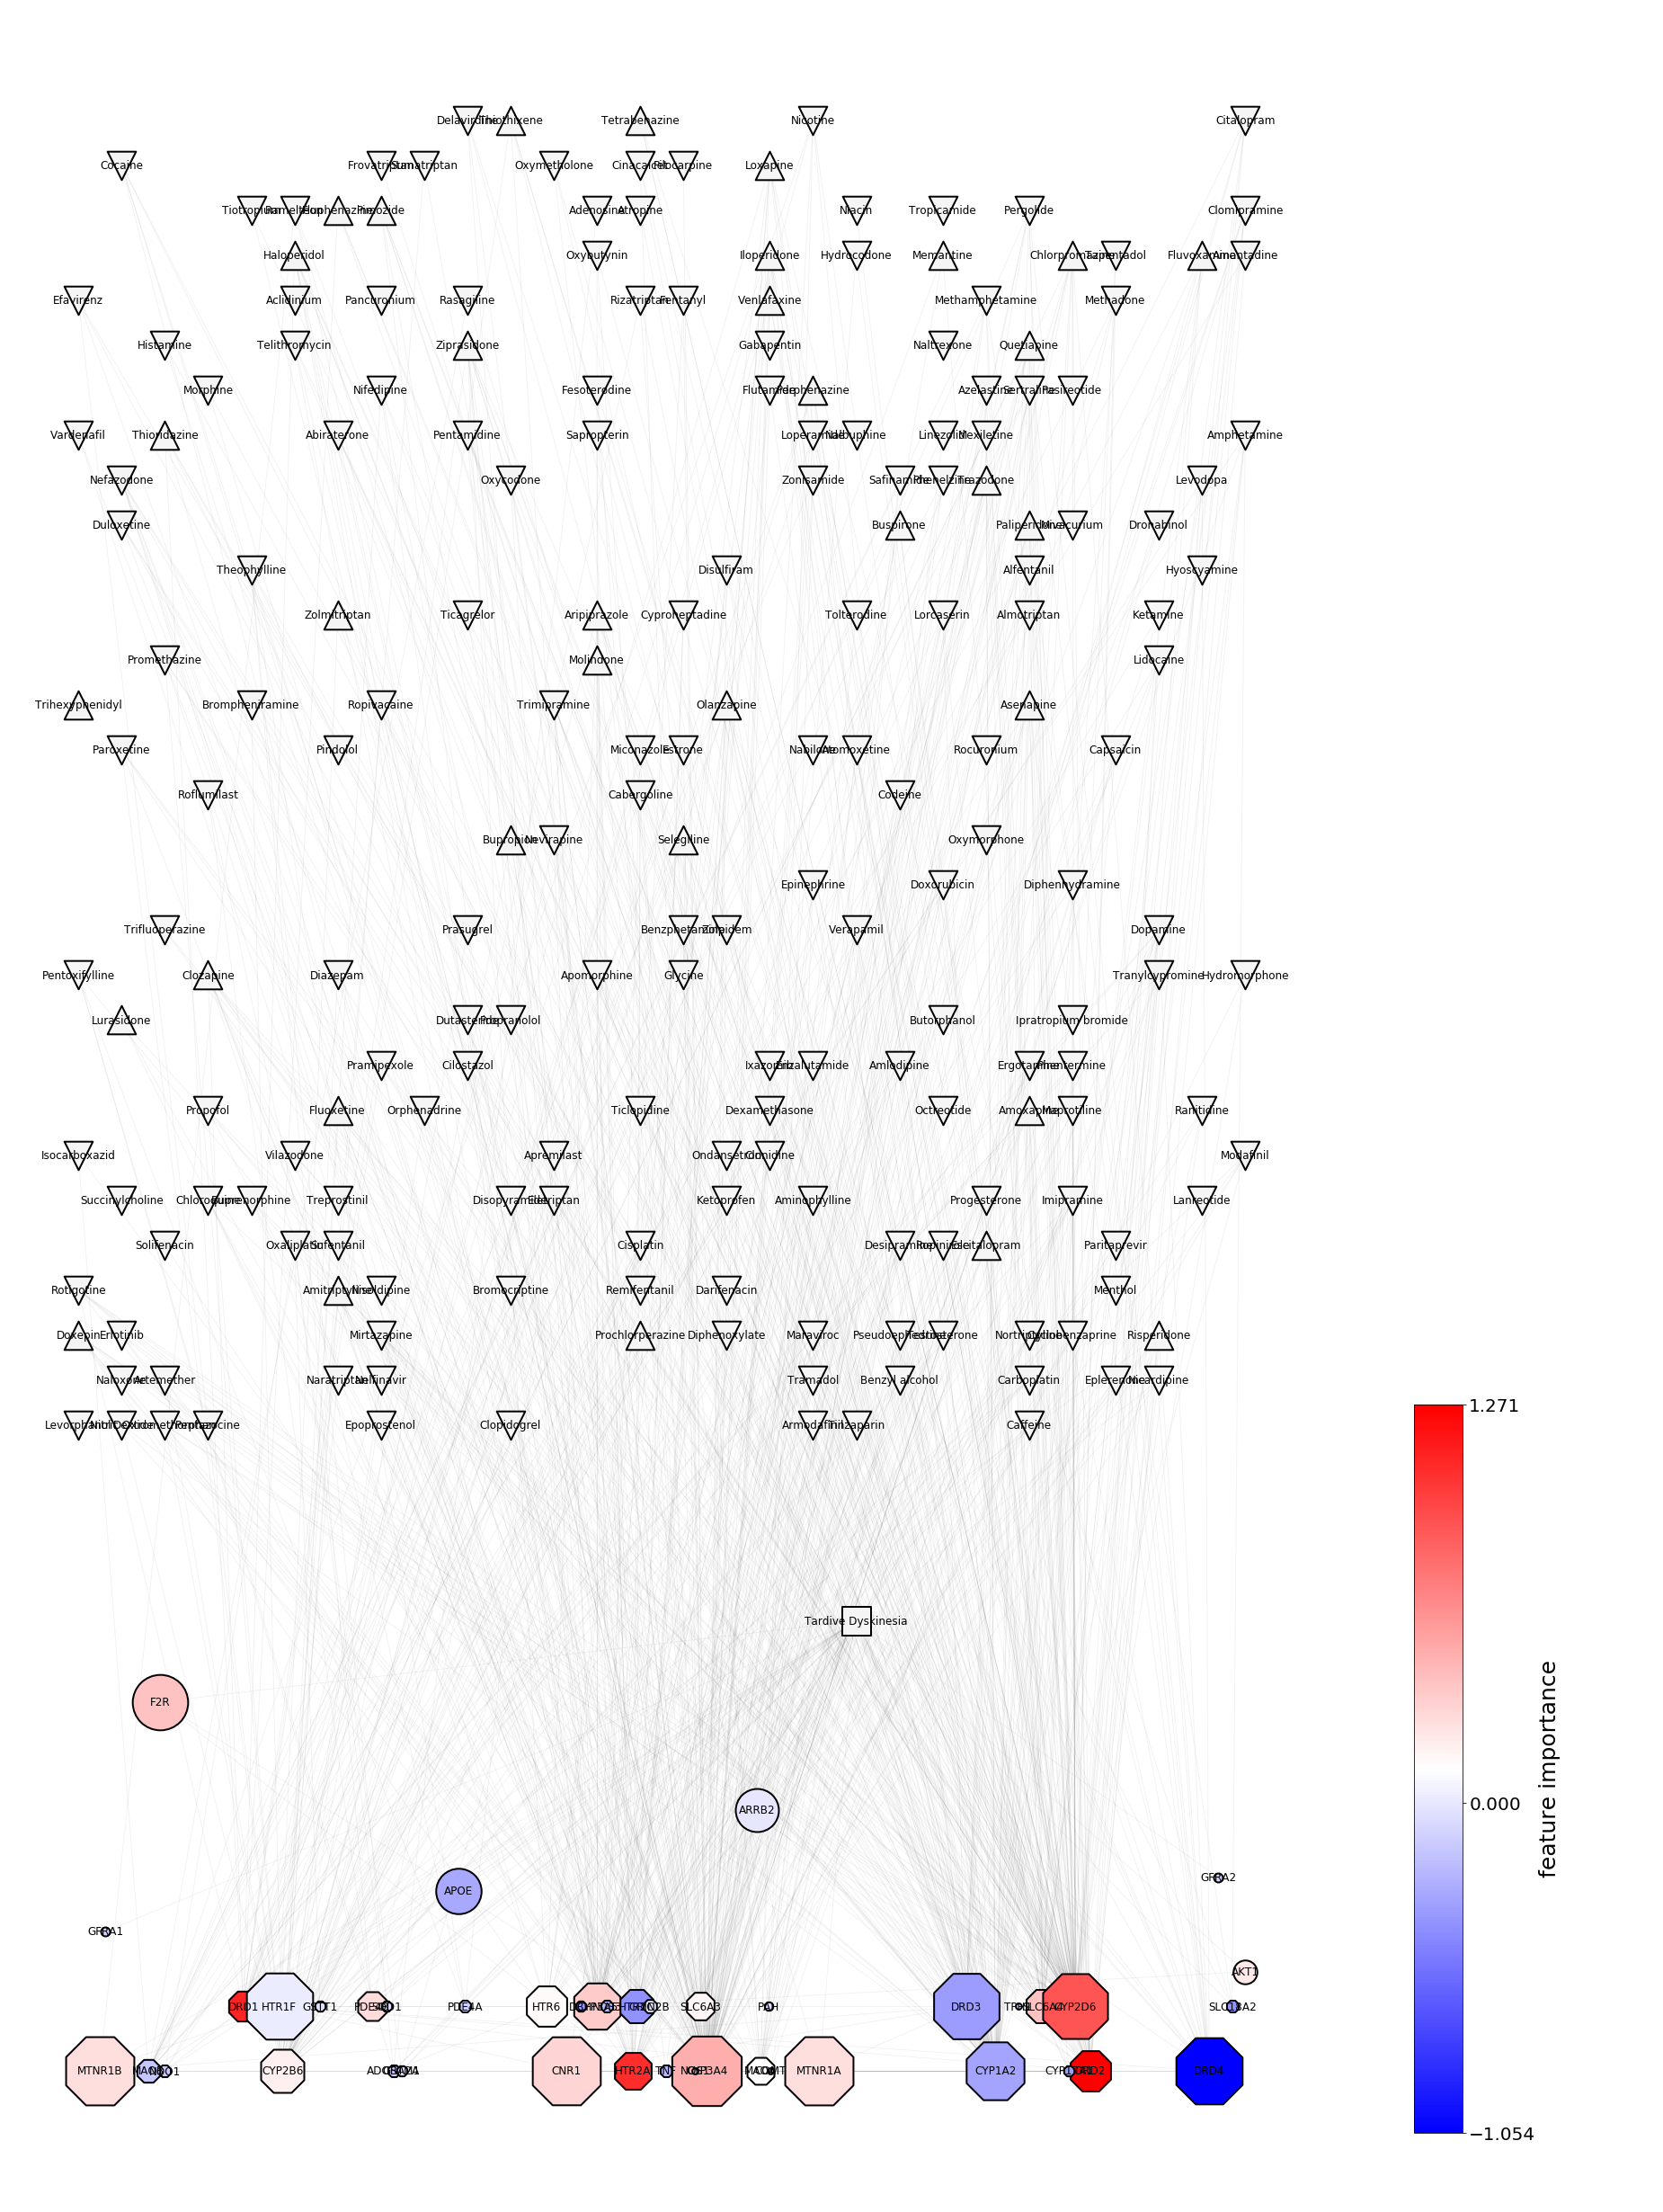

In [18]:
dme_merged_networks = pickle.load(open('dme_merged_networks_dic.pkl','rb'))
dme_merged_node_data = pickle.load(open('dme_merged_node_data_dic.pkl','rb'))

# dme = 'Edema'
dme = 'Tardive dyskinesia'
# dme = 'Peripheral neuropathy'
# dme = 'Pneumonia'
    
dmeG = pickle.load(open(dme_merged_networks[dme],'rb')) # networkX object
net_data_dic = pickle.load(open(dme_merged_node_data[dme],'rb')) # zipped object:(node_list,colors,shapes,sizes,graph_node_types)

# need this dictionary for specifying positions        
node_just_type = {}
dmeG_nodes = [n for n in dmeG.nodes()]
for n in dmeG_nodes:
    net_data_dic[n]['face_color'] = 'whitesmoke'# add default color for all  nodes
    # update type for intermediate nodes
    if net_data_dic[n]['type']:
        node_just_type[n] = net_data_dic[n]['type']
    else:
        net_data_dic[n]['type'] = 'intermediate'
        node_just_type[n] = 'intermediate'
    # update shape for intermediate nodes
    if not net_data_dic[n]['shape']:
        net_data_dic[n]['shape'] = 'o'
    # try changing shape of negative drugs?
    if net_data_dic[n]['type'] == 'negative_drug':
        net_data_dic[n]['shape'] = 'v'
    # add size information for nodes in multiple networks
    if net_data_dic[n]['count']:
        net_data_dic[n]['size'] = net_data_dic[n]['count']*50
    else:
        net_data_dic[n]['size'] = 1000
        
# add feature importance data
fif = fi_dic[dme.lower().replace(' ','_')]
fi_zip = pickle.load(open(fif,'rb'))
fi_data = [(x[1],float(x[0])) for x in fi_zip]
(fi_genes,fi_vals) = zip(*fi_data)
minima = min(fi_vals)
maxima = max(fi_vals)

# save gene, drug-binding status, and fimp in text file
fimp_table = [(x[1],x[0],net_data_dic[x[1]]['type']) for x in fi_zip]
outf = open(dme+"_feature_import_drug_binding_table.txt",'w')
outf.write('\t'.join(["Protein","FeatureImportance","DrugBingingStatus","\n"]))
for (gg,fis,dbst) in fimp_table:
    outf.write('\t'.join([gg,str(fis),dbst,"\n"]))
outf.close()

norm1 = matplotlib.colors.Normalize(vmin=minima, vmax=maxima, clip=True)
mapper1 = cm.ScalarMappable(norm=norm1, cmap=cm.bwr)

# reset face color based on feature importance
for (gene,gval) in fi_data:
    net_data_dic[gene]['face_color'] = mapper1.to_rgba(gval)

# specifications for figure making
fig_width = 5
nrows = 30
pos = get_layered_positions(node_just_type,nrows,fig_width,False)
                
fig,ax = plt.subplots(figsize=(30,45))
ec = nx.draw_networkx_edges(dmeG, pos, alpha=0.05)

for n in dmeG.nodes():
    nc = nx.draw_networkx_nodes(dmeG, pos, nodelist=[n], node_color=net_data_dic[n]['face_color'],
                                node_shape=net_data_dic[n]['shape'], node_size=net_data_dic[n]['size'],
                                linewidths=2.0)
    nc.set_edgecolor('k')
    #if node_just_type[n] == 'drug_target':
    #    n.set_edgecolor('r')
    # nc = nx.draw_networkx_labels(dmeG,pos,labels={n:n},font_size = 12, weight='bold')
ax.axis('off')

# add colorbar information
cax = fig.add_axes([0.85, 0.15, 0.025, 0.25])
cb = fig.colorbar(mapper1, cax=cax, orientation='vertical',ticks = [minima,0,maxima])
cb.ax.tick_params(labelsize=20)
cax.set_ylabel('feature importance',fontsize = 25)
cax = fig.add_axes([0.95, 0.45, 0.025, 0.25])

# save fig
plt.axis('off')
plt.subplots_adjust(right=0.8)
plt.savefig('_'.join([dme,'fimp','network','pos','and','neg','.png']),dpi=400)
#plt.show()   

# create a sub network with pos/neg drugs and pathway proteins with logistic regression values
noi = [n for n in dmeG.nodes if net_data_dic[n]['type']=='positive_drug' or 
       net_data_dic[n]['type']=='negative_drug' or net_data_dic[n]['type']=='phenotype'
       or net_data_dic[n]['face_color'] != 'whitesmoke']
print(len(noi))
dmeG_short = dmeG.subgraph(noi)

fig,ax = plt.subplots(figsize=(30,45))
pos1 = get_layered_positions(node_just_type,nrows,fig_width,True)
ec = nx.draw_networkx_edges(dmeG_short, pos1, alpha=0.05) # use the same pos for now?
for n in noi:
    nc = nx.draw_networkx_nodes(dmeG_short, pos1, nodelist=[n], node_color=net_data_dic[n]['face_color'],
                                node_shape=net_data_dic[n]['shape'], node_size=net_data_dic[n]['size'],
                                linewidths=2.0)
    nc.set_edgecolor('k')
    c = nx.draw_networkx_labels(dmeG,pos1,labels={n:n},font_size = 12, weight='bold')
ax.axis('off')
# add colorbar information
cax = fig.add_axes([0.85, 0.15, 0.025, 0.25])
cb = fig.colorbar(mapper1, cax=cax, orientation='vertical',ticks = [minima,0,maxima])
cb.ax.tick_params(labelsize=20)
cax.set_ylabel('feature importance',fontsize = 25)
cax = fig.add_axes([0.95, 0.45, 0.025, 0.25])

# save fig
plt.axis('off')
plt.subplots_adjust(right=0.8)
plt.savefig('_'.join([dme,'fimp','network','pos','and','neg','justFIMP','.png']),dpi=400)


## 
